In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
label_path = './data/sources/labels.csv'
db_path = './data/nela-eng-2019.db'

## Source Labels

In [3]:
source_labels = pd.read_csv(label_path)

In [4]:
source_labels.head()

,source,aggregated_label,"Pew Research Center, known_by_40%","Pew Research Center, total","Pew Research Center, consistently_liberal","Pew Research Center, mostly_liberal","Pew Research Center, mixed","Pew Research Center, mostly conservative","Pew Research Center, consistently conservative","Wikipedia, is_fake",...,"Allsides, community_agree","Allsides, community_disagree","Allsides, community_label","BuzzFeed, leaning","PolitiFact, Pants on Fire!","PolitiFact, False","PolitiFact, Mostly False","PolitiFact, Half-True","PolitiFact, Mostly True","PolitiFact, True"
0,21stcenturywire,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,left,NaN,NaN,NaN,NaN,NaN,NaN
1,abcnews,0.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,NaN,...,8964.0,6949.0,somewhat agree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,activistpost,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,left,NaN,NaN,NaN,NaN,NaN,NaN
3,addictinginfo,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,left,NaN,NaN,NaN,NaN,NaN,NaN
4,adobochronicles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
source_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 48 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   source                                          260 non-null    object 
 1   aggregated_label                                183 non-null    float64
 2   Pew Research Center, known_by_40%               25 non-null     float64
 3   Pew Research Center, total                      25 non-null     float64
 4   Pew Research Center, consistently_liberal       25 non-null     float64
 5   Pew Research Center, mostly_liberal             25 non-null     float64
 6   Pew Research Center, mixed                      25 non-null     float64
 7   Pew Research Center, mostly conservative        25 non-null     float64
 8   Pew Research Center, consistently conservative  25 non-null     float64
 9   Wikipedia, is_fake                         

* _Reliable_ - class 0
* _Mixed_ - class 1
* _Unreliable_ - class 2

In [9]:
source_labels_aggregated = source_labels[['source', 'aggregated_label']].copy()

In [10]:
source_labels_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   source            260 non-null    object 
 1   aggregated_label  183 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


In [11]:
source_labels['aggregated_label'].isna().sum()

77

In [12]:
source_labels_aggregated = source_labels_aggregated.rename(columns={'aggregated_label':'label'})

Notice that some (77) sources have NaN as aggregated label, maybe we should eliminate these sources? At least not use them for evaluation, but only for training? And how do we handle the ones with label 1 - mixed?

### Extract only fake and real news sources 

In [13]:
fake_sources = source_labels_aggregated.loc[source_labels_aggregated.label == 2.0]

In [14]:
fake_sources.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 259
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  50 non-null     object 
 1   label   50 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


In [11]:
fake_sources = fake_sources.reset_index(drop=True)

In [12]:
fake_sources.index.name = 'id'

In [13]:
fake_sources.head()

,source,label
id,,
0,21stcenturywire,2.0
1,activistpost,2.0
2,ageofautism,2.0
3,bigleaguepolitics,2.0
4,bipartisanreport,2.0


In [14]:
fake_sources = fake_sources.replace(2.0, 1.0)

In [15]:
fake_sources.head()

,source,label
id,,
0,21stcenturywire,1.0
1,activistpost,1.0
2,ageofautism,1.0
3,bigleaguepolitics,1.0
4,bipartisanreport,1.0


In [15]:
real_sources = source_labels_aggregated.loc[source_labels_aggregated.label == 0.0]

In [16]:
real_sources.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83 entries, 1 to 257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  83 non-null     object 
 1   label   83 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


In [17]:
real_sources = real_sources.reset_index(drop=True)

In [18]:
real_sources.index.name = 'id'

In [19]:
real_sources.head()

,source,label
id,,
0,abcnews,0.0
1,airwars,0.0
2,aljazeera,0.0
3,americablognews,0.0
4,bbc,0.0


#### Save to file

In [22]:
fake_sources.to_csv('./data/sources/fake_sources.csv', index = True)
real_sources.to_csv('./data/sources/real_sources.csv', index = True)

## Fetch data

In [20]:
def execute_query_pandas(query):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

def fetch_articles_by_source(source):
    query = "SELECT * FROM newsdata WHERE source='%s'" % source
    articles = execute_query_pandas(query)
    return articles

def fetch_random_articles_by_source(source, n):
    query = "SELECT * FROM newsdata WHERE source='%s' ORDER BY RANDOM() LIMIT %d" % (source, n)
    articles = execute_query_pandas(query)
    return articles

### Select 100 random articles from each real news source

In [24]:
real_sources = pd.read_csv('./data/sources/real_sources.csv')

In [25]:
source_names = real_sources.source

In [39]:
source_names.head()

0            abcnews
1            airwars
2          aljazeera
3    americablognews
4                bbc
Name: source, dtype: object

In [176]:
real_articles = []

start_time = time.time()

for name in source_names:
    articles = fetch_random_articles_by_source(name, 100)
    real_articles.append(articles)
    
print(time.time() - start_time)

1323.8817031383514


In [178]:
df_real_articles = pd.concat(real_articles, ignore_index=True)

In [179]:
df_real_articles.to_csv('./data/real_articles_subset.csv')

### Select all articles from real news sources

In [21]:
real_sources = pd.read_csv('./data/sources/real_sources.csv')

In [22]:
source_names = real_sources.source

In [23]:
real_articles = []

start_time = time.time()

total_len = len(source_names)
counter = 0

for name in source_names:
    print(round((counter / total_len)*100, 2))
    articles = fetch_articles_by_source(name)
    real_articles.append(articles)
    counter += 1
    
print(time.time() - start_time)

0.0
1.2
2.41
3.61
4.82
6.02
7.23
8.43
9.64
10.84
12.05
13.25
14.46


KeyboardInterrupt: 

In [33]:
df_real_articles = pd.concat(real_articles, ignore_index=True)

In [1]:
df_real_articles.to_csv('./data/all/real_articles.csv', encoding='utf-8')

NameError: name 'df_real_articles' is not defined

### Select all articles from fake news sources

In [36]:
fake_sources = pd.read_csv('./data/sources/fake_sources.csv')

In [37]:
fake_source_names = fake_sources.source

In [41]:
fake_source_names.head()

0      21stcenturywire
1         activistpost
2          ageofautism
3    bigleaguepolitics
4     bipartisanreport
Name: source, dtype: object

In [42]:
fake_articles = []

start_time = time.time()

total_len = len(fake_source_names)
counter = 0

for name in fake_source_names:
    print(round((counter / total_len)*100, 2))
    articles = fetch_articles_by_source(name)
    fake_articles.append(articles)
    counter += 1
    
print(time.time() - start_time)

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
766.4039537906647


In [43]:
df_fake_articles = pd.concat(fake_articles, ignore_index=True)

In [44]:
df_fake_articles.to_csv('./data/all/fake_articles.csv', encoding='utf-8')

### Select 100 random articles from each fake news source

In [199]:
fake_sources = pd.read_csv('./data/sources/fake_sources.csv')

In [200]:
fake_source_names = fake_sources.source

In [201]:
fake_sources.head()

,id,source,label
0,0,21stcenturywire,1.0
1,1,activistpost,1.0
2,2,ageofautism,1.0
3,3,bigleaguepolitics,1.0
4,4,bipartisanreport,1.0


In [202]:
fake_articles = []

start_time = time.time()

for name in fake_source_names:
    print(name)
    articles = fetch_random_articles_by_source(name, 100)
    fake_articles.append(articles)
    
print(time.time() - start_time)

21stcenturywire
activistpost
ageofautism
bigleaguepolitics
bipartisanreport
bonginoreport
breaking911
breitbart
clashdaily
cnsnews
collectiveevolution
dailybuzzlive
dailymail
dailystormer
dcgazette
frontpagemagazine
globalresearch
hangthebankers
humansarefree
infowars
intellihub
lewrockwell
liveaction
naturalnews
newsbud
newspunch
newswars
occupydemocrats
pamelagellerreport
personalliberty
prisonplanet
remnantnewspaper
rt
shtfplan
sottnet
theantimedia
thedailystar
thedcclothesline
theduran
thegatewaypundit
thelibertydaily
trueactivist
truepundit
turningpointusa
vaxxter
vdare
veteranstoday
wakingtimes
wnd
zerohedge
987.8500928878784


In [203]:
df_fake_articles = pd.concat(fake_articles, ignore_index=True)

In [204]:
df_fake_articles.to_csv('./data/fake_articles_subset.csv')

### Append labels

In [253]:
real_with_label = pd.merge(df_real_articles, real_sources, on='source')

In [260]:
fake_with_label = pd.merge(df_fake_articles, fake_sources, on ='source')

### Split into train, validation and test (for labeling functions)

In [263]:
# Size from each category (fake, real)
train_size = 1000
validation_size = 250
test_size = 250

random_state = 7897

### Real

In [264]:
real_with_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7893 entries, 0 to 7892
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_x            7893 non-null   object 
 1   date            7893 non-null   object 
 2   source          7893 non-null   object 
 3   title           7893 non-null   object 
 4   content         7893 non-null   object 
 5   author          7893 non-null   object 
 6   url             7893 non-null   object 
 7   published       7893 non-null   object 
 8   published_utc   7893 non-null   int64  
 9   collection_utc  7893 non-null   int64  
 10  id_y            7893 non-null   int64  
 11  label           7893 non-null   float64
dtypes: float64(1), int64(3), object(8)
memory usage: 801.6+ KB


In [265]:
real_train, real_other = train_test_split(real_with_label, train_size=train_size, random_state = random_state)

In [266]:
real_validation, real_test = train_test_split(real_other, 
                                              train_size=validation_size, 
                                              test_size = test_size, 
                                              random_state=random_state)

### Fake

In [267]:
fake_with_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4547 entries, 0 to 4546
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_x            4547 non-null   object 
 1   date            4547 non-null   object 
 2   source          4547 non-null   object 
 3   title           4547 non-null   object 
 4   content         4547 non-null   object 
 5   author          4547 non-null   object 
 6   url             4547 non-null   object 
 7   published       4547 non-null   object 
 8   published_utc   4547 non-null   int64  
 9   collection_utc  4547 non-null   int64  
 10  id_y            4547 non-null   int64  
 11  label           4547 non-null   float64
dtypes: float64(1), int64(3), object(8)
memory usage: 461.8+ KB


In [268]:
fake_train, fake_other = train_test_split(fake_with_label, train_size=train_size, random_state = random_state)

In [269]:
fake_validation, fake_test = train_test_split(fake_other, 
                                              train_size=validation_size, 
                                              test_size = test_size, 
                                              random_state=random_state)

### Concat, shuffle and save datasets

In [286]:
# Train
train_subset = pd.concat([real_train, fake_train], ignore_index=True)
train_subset = shuffle(train_subset)
train_subset = train_subset.reset_index(drop=True)

In [292]:
# Validation
validation_subset = pd.concat([real_validation, fake_validation], ignore_index=True)
validation_subset = shuffle(validation_subset)
validation_subset = validation_subset.reset_index(drop=True)

In [293]:
# Test
test_subset = pd.concat([real_test, fake_test], ignore_index=True)
test_subset = shuffle(test_subset)
test_subset = test_subset.reset_index(drop=True)

In [298]:
# Save to CSV
train_subset.to_csv('./data/train_subset.csv', index=True)
validation_subset.to_csv('./data/validation_subset.csv', index=True)
test_subset.to_csv('./data/test_subset.csv', index=True)

In [303]:
# Make sure that there are no duplicates
check_duplicates = pd.concat([train_subset, validation_subset, test_subset], ignore_index=True)

In [305]:
dup = check_duplicates[check_duplicates.duplicated()]
print(dup)

Empty DataFrame
Columns: [id_x, date, source, title, content, author, url, published, published_utc, collection_utc, id_y, label]
Index: []


### Source 0: 21st Century Wire

In [107]:
source_0 = fake_sources.source[0]
label_0 = fake_sources.label[0]
print(source_0, label_0)

21stcenturywire 1.0


In [113]:
start_time = time.time()
articles_0 = fetch_random_articles_by_source(source_0, 100)
print(time.time() - start_time)

29.457087993621826


In [115]:
articles_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              100 non-null    object
 1   date            100 non-null    object
 2   source          100 non-null    object
 3   title           100 non-null    object
 4   content         100 non-null    object
 5   author          100 non-null    object
 6   url             100 non-null    object
 7   published       100 non-null    object
 8   published_utc   100 non-null    int64 
 9   collection_utc  100 non-null    int64 
dtypes: int64(2), object(8)
memory usage: 7.9+ KB


In [19]:
print(articles_0.content[0])

Journalist Robert Inlakesh reported live from the streets of London earlier this week, covering a protest against the U.K. Government’s ‘Trump train’ support of regime change on Venezuela.



 Protesters marched on the streets of London in the late afternoon on Monday. Protests like these aren’t covered by the mainstream press.

During this captivating 13-minute video, Inlakesh speaks with some of the Venezuelan protesters to get their candid views on the current crisis unfolding in their home country. The people gathered at this demonstration are in clear opposition to the regime change tactics used by foreign powers on oil-rich nations like Venezuela. Watch:


### Source 1: ABC News

In [169]:
source_1 = real_sources.source[0]
label_1 = real_sources.label[0]
print(source_1, label_1)

abcnews 0.0


In [170]:
articles_1 = fetch_articles_by_source(source_1)

In [173]:
articles_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2861 entries, 0 to 2860
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2861 non-null   object
 1   date            2861 non-null   object
 2   source          2861 non-null   object
 3   title           2861 non-null   object
 4   content         2861 non-null   object
 5   author          2861 non-null   object
 6   url             2861 non-null   object
 7   published       2861 non-null   object
 8   published_utc   2861 non-null   int64 
 9   collection_utc  2861 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 223.6+ KB


In [174]:
articles_1.to_csv('./data/sample.csv', index=True)

Looks like we want to clean it by removing \n's etc. 

# Date analysis on 5 first sources

In [25]:
source_labels_without_nan = source_labels_aggregated.dropna()

In [26]:
source_labels_without_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 0 to 259
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   source            183 non-null    object 
 1   aggregated_label  183 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.3+ KB


In [27]:
first_five = source_labels_without_nan.head(5)

In [28]:
# Fetch articles from database

first_five_articles = []

for index, row in first_five.iterrows():
    source = row.source
    articles = fetch_articles_by_source(source)
    first_five_articles.append(articles)

In [38]:
df_articles = pd.concat(first_five_articles, ignore_index=True)

In [39]:
df_articles.head()

,id,date,source,title,content,author,url,published,published_utc,collection_utc
0,21stcenturywire--2019-01-30--WATCH Londoners P...,2019-01-30,21stcenturywire,WATCH: Londoners Protest UK Government’s Regim...,Journalist Robert Inlakesh reported live from ...,21wire,https://21stcenturywire.com/2019/01/30/watch-l...,2019-01-30 17:59:19+00:00,1548889159,1567550189
1,21stcenturywire--2019-07-24--Digital Wonderlan...,2019-07-24,21stcenturywire,"Digital Wonderland: AI, Transhumanism and Faux...","If you watch the sci-tech news regularly, you ...",21wire,https://21stcenturywire.com/2019/07/24/digital...,2019-07-24 07:20:53+00:00,1563967253,1567535914
2,21stcenturywire--2019-07-24--South Korean Air ...,2019-07-24,21stcenturywire,South Korean Air Force Fires Warning Shots at ...,"Yesterday, Russia and China carried out what i...",21wire,https://21stcenturywire.com/2019/07/24/south-k...,2019-07-24 07:33:51+00:00,1563968031,1567535914
3,21stcenturywire--2019-04-07--Will Kurds merge ...,2019-04-07,21stcenturywire,Will Kurds merge with ISIS as U.S combines pro...,Kurdish fighters have been used by the US to o...,21wire,https://21stcenturywire.com/2019/04/07/will-ku...,2019-04-07 08:17:00+00:00,1554639420,1567543653
4,21stcenturywire--2019-04-07--Whats Behind Jere...,2019-04-07,21stcenturywire,What’s Behind Jeremy Hunt’s Choice of Amal Clo...,\n\n IMAGE: Jeremy Hunt and Amal Clooney campa...,Nina Cross,https://21stcenturywire.com/2019/04/07/whats-b...,2019-04-07 11:36:59+00:00,1554651419,1567543653


In [67]:
df_articles.date = pd.to_datetime(df_articles.date)

In [70]:
df_dates = df_articles.date.copy()

In [84]:
date_counts = df_dates.value_counts().sort_index().reset_index()
date_counts.columns = ['date', 'occurences']

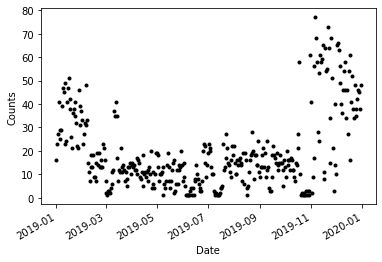

In [92]:
fig, ax = plt.subplots()
ax.plot_date(date_counts.date, date_counts.occurences, fmt='.', color='k')
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Counts')
plt.show()